In [20]:
from notebook_util import *
%matplotlib inline

In [21]:
from minee.data.mix_gaussian import MixedGaussian

In [22]:
np.random.seed(0)
sample_size = 200
rho1 = 0.9
data = MixedGaussian(sample_size=sample_size,rho1=rho1).data
data_t = torch.FloatTensor(data).to(device)

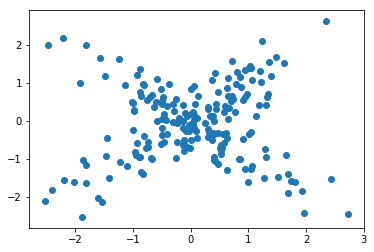

In [23]:
plt.scatter(data[:,0],data[:,1])

In [24]:
data_marginal = sample_batch(data,batch_size=sample_size,sample_mode='marginal')
data_marginal_t = torch.FloatTensor(data_marginal).to(device)

In [29]:
batch_size = sample_size
net = []
mi_estimate = []
ma_rate = 0.1
ma_ef = 1
lr = 1e-3
mine_net = MineNet()
mine_net.to(device)
mine_net_optim = optim.Adam(mine_net.parameters(),lr=lr)

Automatically load previous results from db file if exists

In [30]:
fname = 'mix_gaussian.db'
if os.path.exists(fname):
    with open(fname,'rb') as f:
        net,mi_estimate,ma_et = dill.load(f)
        mine_net.load_state_dict(net[-1])
        print('results loaded from '+fname)

Repeately run the following to continue to train

In [31]:
for i in range(1000):
        mine_net_optim.zero_grad()
        batch_data = sample_batch(data,batch_size=batch_size,sample_mode='joint')
        batch_data_marginal = sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        #batch_data_marginal = np.random.multivariate_normal(mean=[0,0],cov=[[1,0],[0,1]],size=3000)
        batch_data_t = torch.FloatTensor(batch_data).to(device)
        batch_marginal_t = torch.FloatTensor(batch_data_marginal).to(device)
        f = mine_net(batch_data_t)
        ef = torch.exp(mine_net(batch_marginal_t))
        mi_lb = torch.mean(f) - torch.log(torch.mean(ef))
        #loss = -mi_lb
        ma_ef = (1-ma_rate)*ma_ef + ma_rate*torch.mean(ef)
        loss = -(torch.mean(f) - (1/ma_ef.mean()).detach()*torch.mean(ef))
        loss.backward()
        mine_net_optim.step()    
        mi_estimate = np.append(mi_estimate,(torch.mean(mine_net(data_t)) - torch.log(torch.mean(torch.exp(mine_net(data_marginal_t))))).item())
net = np.append(net,mine_net.state_dict())

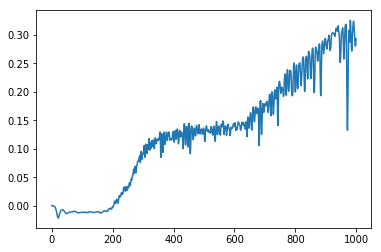

In [32]:
plt.plot(mi_estimate)

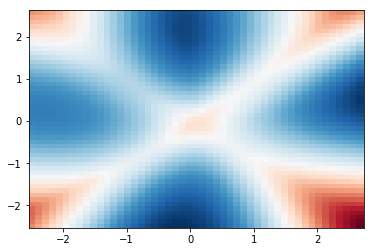

In [33]:
getHeatMap(mine_net,data,grids=[50,50])

To save new results to a db file using the following code, delete the existing db file.

In [34]:
if not os.path.exists(fname):
    with open(fname,'wb') as f:
        dill.dump([net,mi_estimate,ma_et],f)
        print('results saved to '+fname)

results saved to mix_gaussian.db
